In [40]:
from igraph import *
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
import pandas as pd
from itertools import chain
import itertools
import pandas as pd
import hickle as hkl
import time
%matplotlib inline 


class Epidemy(Graph):
    '''Epidemy extends the igraph's class Graph. Ciao
    The additional functionalities are:
    
    1 Built-in getters for graph metrics
        1.1 Plotting
            a)
            b)
        1.2 Metrics
            a) distribution model
            b) eggr
    
    '''
    graph = None
    patient_zero = None
    sentinels = None
    global I
    
    def __init__(self, graph_edge_list, patient_zero = None, sentinels = None):
        '''The compartment label is a byte that can take values 0, 1 and 2, indicating respectivly
        0 - Suscebtible node
        1 - Infected node'''
        
        
        self.graph = Graph.Read_Ncol(graph_edge_list, directed=False)
        self.patient_zero = patient_zero
        self.sentinels = sentinels
             
    
    #setters  
    def setPatientZero(self, patient_zero):
        if patient_zero == None:
            self.patient_zero = None
        else:
            self.patient_zero = set(patient_zero)
        
    def setSentinels(self, sentinels):
        if sentinels == None:
            self.sentinels = None
        else:
            self.sentinels = set(sentinels)
        
    def resetSentinels(self):
        self.graph.vs["iteration"] = np.nan
        
    def resetNodes(self):
        self.graph.vs["compartment"] = np.zeros(len(self.graph.vs), dtype = np.uint8)
    
     
    #getters
    def getDegreeDistribution(self):
        x,y = np.unique(self.graph.degree(), return_counts=True)
        print(len(self.graph.degree()))
        return (x,y)
    
    def getMaxDegreeVertex(self):
        return self.graph.vs[self.graph.degree().index(self.graph.maxdegree())]
    
    def getSentinelsIteration(self):
        return [i["iteration"] for i in self.graph.vs[self.sentinels]]

                
    def getRankingCombinations(self, number):
        aux = np.transpose(sorted(np.column_stack((a.graph.vs.indices, self.graph.degree())), key=lambda x: x[1]))[0]
        rankings = [("worst_degree", aux[:number]), ("best_centrality", aux[-number:])]
        aux = np.transpose(sorted(np.column_stack((a.graph.vs.indices, self.graph.closeness())), key=lambda x: x[1]))[0].astype(int)
        rankings += [("worst_closeness", aux[:number]), ("best_closeness", aux[-number:])]
        aux = np.transpose(sorted(np.column_stack((a.graph.vs.indices, self.graph.betweenness(directed=False))), key=lambda x: x[1]))[0].astype(int)        
        rankings += [("worst_betweenness", aux[:number]), ("best_betweenness", aux[-number:])] 
        aux = np.transpose(sorted(np.column_stack((a.graph.vs.indices, self.graph.pagerank(directed=False))), key=lambda x: x[1]))[0].astype(int)
        rankings += [("worst_pagerank", aux[:number]), ("best_pagerank", aux[-number:])]  
        return itertools.permutations(rankings, 2)
        
    
    #Epidemy Utilities
    def printDegreeDistribution(self, loglog=False):
        '''Prints the degree distirbution of the underlying network using a logarithmic scale'''
        x,y = self.getDegreeDistribution()
        if loglog:
            plt.scatter(np.log(x), np.log(y))
        else:
            plt.scatter(x, y)
        plt.show()
    
    def getRankings(self, number):
        try:
            rankings = hkl.load(dataset[:-4]+"_rankings.hkl")
            print 1111111111111
        except:
            rankings = list(self.getRankingCombinations(number))
            hkl.dump(rankings, dataset[:-4]+"_rankings.hkl")
        return rankings
    
    def N_SIR(self, num_simulation = 20, **kwargs):
        seq = []
        for i in range(num_simulation):
            #print("Simulation number", i+1)
            #print(kwargs)
            self.SIR(**kwargs)
            print(len(self.graph.vs[self.sentinels]))
            seq = seq + [np.nan if pd.isnull(v["iteration"]) else float(v["iteration"]) for v in self.graph.vs[self.sentinels]]
            print(len(seq))
        return seq
            
        
    #Epidemic Models
    def SIR(self, beta = 0.5, mu = 0.1,
            patient_zero = None, num_pat = 5,
            sentinels = None, num_sen = 5,
            friend_paradox = False, verbose= False):
        """Simulate an epidemy outbreaks using a sir model"""
        
        
        if sentinels is not None:
            print("No_paradox")
            self.setSentinels(sentinels)
        elif (self.sentinels is None) & (sentinels is None) :
            self.setSentinels(np.random.choice(self.graph.vs.indices, size=num_sen, replace=False))
            print("No sentinels detected. Random selection: ", self.sentinels)
        
        if friend_paradox:
            neighbors = np.unique(list(chain.from_iterable([self.graph.neighbors(v) for v in self.sentinels])))
            self.setSentinels(np.random.choice(neighbors, size =len(self.sentinels), replace=False))
            
            #neighbors = [np.random.choice(self.graph.neighbors(v)) for v in sentinels]
            #self.sentinels = neighbors
            #print("numero sentinelle", len(neighbors), len(sentinels))
            print(self.sentinels)
    
        #print("sentinels", self.sentinels)
        
        if patient_zero is not None:
            I = set(patient_zero)
        elif self.patient_zero is not None:
            I = set(self.patient_zero)
        else:
            I = set(np.random.choice(self.graph.vs.indices, size= 5,replace =False))
            print("No patient zero detected. Random selection: ", I)
        
        self.resetNodes()
        self.resetSentinels();
        
        development = []
        if verbose:
            print("Starting SIR simulation", "beta:", beta, "mu", mu,
              "sentinels:", self.sentinels, "patient_zero: ", self.patient_zero, "friend_paradox", friend_paradox)
        
        start = time.time()
        for iteration in itertools.count():
            if(len(I)==0):
                break
                
            if verbose:   
                print("Nodes in the Infected Compartment: ",len(I))
            
            dI = set([j for j in list(itertools.chain.from_iterable(self.graph.neighborhood(I)))
                      if self.graph.vs[j]["compartment"] == 0 and np.random.random() < beta])
            self.graph.vs[dI]["compartment"] = 1 


            # Finds new removed nodes and update the status
            dR = set([k for k in I if np.random.random() < mu])
            self.graph.vs[dR]["compartment"] = 2
            
            self.graph.vs[dI & set(self.sentinels)]["iteration"] = time.time()-start
            

            I = (I | dI) - (dR)
            
            development +=  [len(I)]
        return development

dataset = "facebook.txt"
a = Epidemy(dataset)
#a.printDegreeDistribution(loglog = True) 
#q = a.SIRRankedSimulation()

Orkut is a free on-line social network where users form friendship each other. Orkut also allows users form a group which other members can then join. We consider such user-defined groups as ground-truth communities. We provide the Orkut friendship social network and ground-truth communities. This data is provided by Alan Mislove et al.

We regard each connected component in a group as a separate ground-truth community. We remove the ground-truth communities which have less than 3 nodes. We also provide the top 5,000 communities with highest quality which are described in our paper. As for the network, we provide the largest connected component.



The graph is undirected.

# Digital Epidemiology Assignment 1

In this homework we are going to use a real social netwrok in order to simulate and analyze a SIR epidemy. 

We are going to use Youtube's community graph. I decided to use this dataset because its connections are intrests-based, given me the possibiliy to simulate an empidemy on a network based on a real-social interactions.

Those are some statistics about Youtube's community graph:

* Nodes 1134890	
* Edges	2987624 (undirected)
* Connected components 1
* Average clustering coefficient	0.0808
* Number of triangles	3056386
* Fraction of closed triangles	0.002081
* Diameter (longest shortest path)	20



## Part 1 
 
I decided to implement an extended version of the **graph** class of the igraph package; this class is called Epidemy. Epidemy class is freely aviable for download from the following link: https://github.com/aalto1/pandemia

However to make things easier correction-wise, I included my class at the bottom of this notebook.

Essentially the epidemy class implements the following functionalities:

* Create Epidemy Object given a Network and an Epidemic Model
* Simulate on the given network the given Epidemic Model
* Get Network metrics
    * Degree Score
    * Closeness Score
    * Betwenness Score
    * Pagerank Score


In this way we can logically separate our epidemiological analysis from its actual implementation. If the revisor is intrested is intrested in my technical solution the code is widely commented and explained.


### 1.1 Compute and Plot a Social Network Degree [X]


In this section we are required to load in memory the selected graph, Youtube's community graph in our case, and plot its degree distribution.

1134890


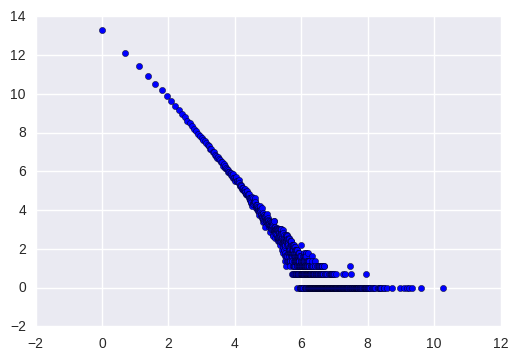

In [27]:
dataset = "youtube.txt"
a = Epidemy(dataset)
a.printDegreeDistribution(loglog = True)

As we can see from the plot, Youtube's community graph degree distribution has the typical power law of social networks.

### 1.2 SIR Epidemic Model Simulation [X]

We are now require to perform a single plain simulatation of a SIR epidemy and shplot its epidemic curve:

/home/aalto/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


('No sentinels detected. Random selection: ', set([38680, 1046624, 389090, 1020901, 866798]))


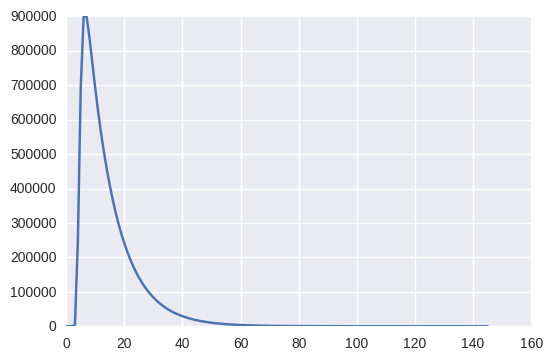

In [28]:
epidemic_curve = a.SIR(beta = 0.9, mu = 0.1, patient_zero=a.graph.vs.indices[-10:])
plt.plot(epidemic_curve)
plt.show()

## Part 2

In this section we are going show how to monitor an epidemic outbreak and how the different epidemilogical parameters influence its dynamics. More specifically we are going to use epdiemy sentinels, which are a random set o N nodes of the graph which will record the epidemy arrival time at their position.

### 2.1 SIR Simulation with Static Sentinels [ ] 

In this subsection we are required to monitor an epidemic outbreak. To do this we can exploit the sentinel built in functionality provided by the class **Epidemy**. Indeed, since in the previous section we did not specified any sentinel, the class already choosed at random some of them. However we are intrested in running multiple simulation of the same epidemy, so we are going to use the **N_SIR**, which runs **N** simulations of a given epidemic profile. 

Once the simulation is done, the code plots a boxplot representing the time arrival distribution of the selected sentinels for each of the simulations

In [36]:
df1 = pd.DataFrame([])
a.N_SIR(beta = 0.9, mu = 0.1)             
df1 = pd.DataFrame(a.N_SIR(num_simulation=100, beta = 0.9, mu = 0.8), columns = ["beta_0.9_mu_0.1"])  
sb.boxplot(df1)
plt.show()

/home/aalto/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


('No sentinels detected. Random selection: ', set([856, 2489, 3951, 2261, 1927]))
('No patient zero detected. Random selection: ', set([1131, 2066, 819, 1585, 1609]))
5
5
('No patient zero detected. Random selection: ', set([1673, 1513, 2627, 1916, 2135]))
5
10
('No patient zero detected. Random selection: ', set([24, 3617, 1491, 1877, 789]))
5
15
('No patient zero detected. Random selection: ', set([2680, 1185, 986, 3367, 2583]))
5
20
('No patient zero detected. Random selection: ', set([312, 2930, 2419, 4014, 1011]))


KeyboardInterrupt: 

### 2.2 SIR Simulation with Dynamic Random Sentinels, Seeds and Parameters [ ]

We are now going to try different parameter and input combination, in order to get a better understanding on how the different factor effect the epidemic curve.

* SIR parameters ($\mu$, $\beta$)
* Different sentinels at each loop
* Different number of sentinels
* No overlap between seed and sentinels
* Different seed at each loop
* Multiple Seeds

We can obtain those combination just by Most of those features are easily simulable thanks via the built-in functionalities of the epidemy class.

In [ ]:

df1 = pd.DataFrame([])
for i in range(5):
    rnd_beta, rnd_mu = np.random.random(),np.random.random()
    rnd_pat, rnd_sen = np.random.randint(1,a.graph.vcount()),np.random.randint(1,a.graph.vcount())
    simulation_name = "_".join(map(lambda x: str(x),[rnd_beta,rnd_mu,rnd_pat,rnd_sen])[:-1])                                                                       
    df1[simulation_name] = a.N_SIR(num_simulation=10, beta = rnd_beta, mu = rnd_mu,
                  patient_zero= None, num_pat = rnd_pat,
                  sentinels = None, num_sen = rnd_sen)  
sb.boxplot(df1)
plt.show()


### 2.3 SIR Simulation with Static Top-Ranked Sentinels [ ]

Now we want to investigate if exploiting centrality metrics it is possible to detect the epidemy diffusion more quickly or on the other hand exploiting those nodes having a stronger and faster outbreak.

First of all we compute the top-1000 and worst-1000 nodes for the following mesures:

* Degree Distribution
* Closeness Centrality
* Betweenness Centrality
* Pagerank Centrality


1111111111111
[(('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('best_centrality', array([1149, 1285, 1373, 2154, 1490,    0, 1821,  352,  351,  107]))), (('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('worst_closeness', array([1837, 1946, 1844, 1889, 1894, 1895, 1920, 1986, 1888, 1930]))), (('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('best_closeness', array([362, 349, 366, 348, 171, 351, 371, 350,  58, 107]))), (('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('worst_betweenness', array([11, 12, 15, 18, 32, 33, 35, 37, 42, 43]))), (('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('best_betweenness', array([ 350,   58, 1710, 1843,    0,  571,  352, 1821,  351,  107]))), (('worst_degree', array([ 11,  12,  15,  18,  37,  43,  74, 114, 209, 210])), ('worst_pagerank', array([3059, 3139, 3195, 3335, 3342, 3415, 3435,  397,  404,  582]))), 

/home/aalto/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10
10
No_paradox
10
20
No_paradox
10
30
No_paradox
10
40
No_paradox
10
50
No_paradox
10
60
No_paradox
10
70
No_paradox
10
80
No_paradox
10
90
No_paradox
10
100
No_paradox
10
110
No_paradox
10
120
No_paradox
10
130
No_paradox
10
140
No_paradox
10
150
No_paradox
10
160
No_paradox
10
170
No_paradox
10
180
No_paradox
10
190
No_paradox
10
200
No_paradox
10
10
No_paradox
10
20
No_paradox
10
30
No_paradox
10
40
No_paradox
10
50
No_paradox
10
60
No_paradox
10
70
No_paradox
10
80
No_paradox
10
90
No_paradox
10
100
No_paradox
10
110
No_paradox
10
120
No_paradox
10
130
No_paradox
10
140
No_paradox
10
150
No_paradox
10
160
No_paradox
10
170
No_paradox
10
180
No_paradox
10
190
No_paradox
10
200
No_paradox
10
10
No_paradox
10
20
No_paradox
10
30
No_paradox
10
40
No_paradox
10
50
No_paradox
10
60
No_paradox
10
70
No_paradox
10
80
No_paradox
10
90
No_paradox
10
100
No_paradox
10
110
No_paradox
10
120
No_paradox
10
130
No_paradox
10
140
No_paradox
10
150
No_paradox
10
160
No_paradox
10
170
No_paradox
1

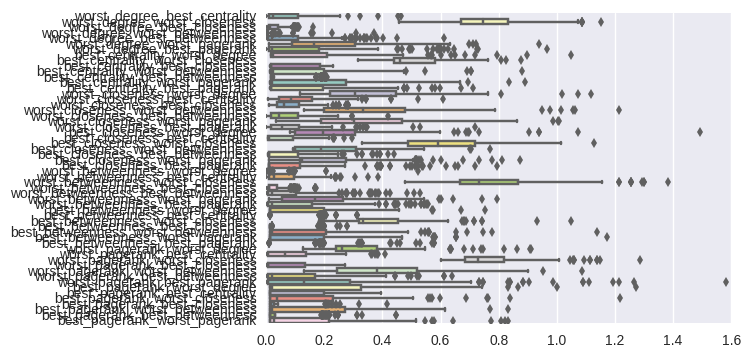

In [46]:
rankings = a.getRankings(10)

df = SIRRankedSimulation(a, rankings)
sb.boxplot(df, orient="h", palette="Set3")
plt.show()

In [45]:
def SIRRankedSimulation(g, rankings):
        df = pd.DataFrame([])
        for ranking in rankings:
            seq = []
            #print(ranking[0][0], ranking[0][1], ranking[1][0], ranking[1][1])
            df[str(ranking[0][0])+"_"+str(ranking[1][0])] = g.N_SIR(patient_zero = ranking[0][1], sentinels = ranking[1][1])
        return df


In [ ]:
z1 = q.iloc[: , :len(q)/20]
z2 = q.iloc[: , len(q)/2:]
sb.boxplot(z1)
plt.show()

## Part 3 

In this final section we are going to investigate some aspect of epidemy detection when there is no global information on the graph topology.

### 3.1 Friend Paradox and Local Centrality Measures [ ]

In this subsection we are intrested in minimizing the **detection time** of our epidemy by the sentinels. We suppose that we do not have any information about the global topology of the graph, but only the informations about the neighbours of our seed nodes.

In order to achive this result we are going to exploit the so called **friend paradox**, which we are going to discuss in section 3.2

$\mu=\frac{\sum_{v\in V} d(v)}{|V|}=\frac{2|E|}{|V|}.$

$\frac{\sum_{v\in V} d(v)^2}{2|E|}=\mu + \frac{\sigma^2}{\mu},$

where $ {\sigma}^{2} $ is the variance of the degrees in the graph

In [10]:
df_friend = pd.DataFrame([])

rnd_sen = np.random.choice(a.graph.vs.indices, size = 10, replace = False).tolist()
print(rnd_sen)
df_friend["f_paradox"] = a.N_SIR(num_simulation = 100, beta = 0.4, mu = 0.1,
                                 sentinels = rnd_sen, friend_paradox = True)
df_friend["f_random"]  = a.N_SIR(num_simulation = 100, beta = 0.4, mu = 0.1, 
                                 sentinels = rnd_sen, friend_paradox = False)

sb.boxplot(df_friend, orient="h", palette="Set3")
plt.show()

[949, 3320, 1718, 3468, 773, 3191, 335, 923, 3885, 858]
No_paradox
set([1561, 1221, 1481, 3054, 815, 3063, 1465, 3066, 3006, 639])
('No patient zero detected. Random selection: ', set([2678, 2220, 3973, 3854, 287]))


/home/aalto/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10
10
No_paradox
set([0, 3234, 1539, 3364, 1284, 1265, 1617, 3449, 3256, 3353])
('No patient zero detected. Random selection: ', set([1616, 2728, 3211, 1789, 1695]))
10
20
No_paradox
set([3008, 432, 3265, 1500, 1328, 1075, 777, 3354, 3420, 3295])
('No patient zero detected. Random selection: ', set([587, 1315, 3676, 2597, 3293]))
10
30
No_paradox
set([1349, 3110, 3175, 3464, 1478, 107, 1427, 1075, 3261, 1726])
('No patient zero detected. Random selection: ', set([1144, 1516, 892, 1686, 2590]))
10
40
No_paradox
set([2947, 2984, 777, 3146, 3152, 3251, 1084, 3101, 1278, 1311])
('No patient zero detected. Random selection: ', set([3250, 2947, 1140, 2398, 3814]))
10
50
No_paradox
set([578, 2980, 3251, 1352, 2989, 1810, 1043, 1557, 572, 1373])
('No patient zero detected. Random selection: ', set([3616, 2090, 867, 397, 3711]))
10
60
No_paradox
set([1091, 3175, 3135, 1226, 844, 3157, 1161, 3419, 1045, 3423])
('No patient zero detected. Random selection: ', set([568, 3898, 523, 877, 1878]))
10


### 3.2 Why the Friendship Paradox Works*? (and also the local centrality measures) [ ]

The Friendship Paradox states that on average given a node in a graph (that we can imagine as a real person), on average its negihbours (that we can think as its friend) will have an higher degree than the node itself. Exploiting this characteristic is possible to choose from our neighbours the ones that have an higher degree randomly being sure that on average those nodes will have a higher degree, hence an higher porbability to detect the epidemy out break.

We can mix this approach using a also some metrics nalysis an 

## Part 4 (Epidemy Class) [ ]

The epidemy class is the core of this notebook. It extends the igraph graph class adding the methods required to premor an epidemy analysis smoothly

In [ ]:
planets = sns.load_dataset("planets")
planets

In [ ]:
import numpy as np
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
ax = sns.boxplot(x="distance", y="method", data=planets,
                 whis=np.inf, color="c")

# Add in points to show each observation
sns.stripplot(x="distance", y="method", data=planets,
              jitter=True, size=3, color=".3", linewidth=0)


# Make the quantitative axis logarithmic
ax.set_xscale("log")
sns.despine(trim=True)
plt.show()

In [ ]:
 def getBestVertexByCentrality(self, number):
        aux = sorted(self.graph.degree())
        return (aux[:number], "worst_degree", aux[-number:], "best_centrality")
        
    def getBestVertexByCloseness(self, number):
        aux = sorted(self.graph.closeness())
        return (aux[:number], "worst_closeness", aux[-number:], "best_closeness")
        
    def getBestVertexByBetweennes(self, number):
        aux = sorted(self.graph.pagerank())
        return (aux[:number], "worst_betweenness", aux[-number:], "best_betweenness"]
    
    def getBestVertexByPagerank(self, number):
        aux = sorted(self.graph.pagerank(directed=False))
        return ((aux[:number], "worst_pagerank"), (aux[-number:], "best_pagerank")]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)

# basic plot
plt.boxplot(data)

# notched plot
plt.figure()
plt.boxplot(data, 1)

# change outlier point symbols
plt.figure()
plt.boxplot(data, 0, 'gD')

# don't show outlier points
plt.figure()
plt.boxplot(data, 0, '')

# horizontal boxes
plt.figure()
plt.boxplot(data, 0, 'rs', 0)

# change whisker length
plt.figure()
plt.boxplot(data, 0, 'rs', 0, 0.75)

# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low), 0)
data.shape = (-1, 1)
d2.shape = (-1, 1)
# data = concatenate( (data, d2), 1 )
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2, 0]]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)

plt.show()
